In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir affectNetHQDB

In [ ]:
import shutil
shutil.copy("/content/drive/MyDrive/AI_Datasets/affectnwtHQ.zip", "/content/affectNetHQDB")

'/content/affectNetHQDB/affectnwtHQ.zip'

In [ ]:
%cd /content/affectNetHQDB

/content/affectNetHQDB


In [ ]:
import os

In [ ]:
import zipfile
for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, "r") as zip_file:
            zip_file.extractall()
        os.remove(file)

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import glob
import torch.optim as optim
import time
import cv2
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import torchvision.datasets as datasets
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
%matplotlib inline

In [ ]:
data_dir = '/content/affectNetHQDB/'
IMAGE_DIM=256
print(os.listdir(data_dir))

['disgust', 'happy', 'fear', 'surprise', 'anger', 'sad', 'neutral']


In [ ]:
def load_data(path, test_split, val_split, batch_size, input_size):
    
    ######## Write your code here ########
    
    transform_dict = {
                    'src': transforms.Compose([
                      
                      transforms.Resize(input_size),
                      transforms.RandomHorizontalFlip(), 
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225]),
     ])}

    data = datasets.ImageFolder(root=path, transform=transform_dict['src'])

    dataset_size = len(data)
    
    train_size = int((1-(test_split+val_split))*dataset_size)+1
    test_size = int(test_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_dataset, test_dataset, val_dataset= td.random_split(data, [train_size, test_size, val_size])

    data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
    data_loader_test  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
    data_loader_val  = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
    
    return data_loader_train, data_loader_test, data_loader_val

(512, 512, 3)
(995, 995, 3)
(512, 512, 3)


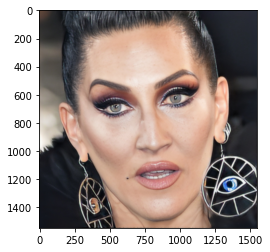

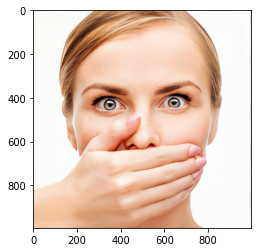

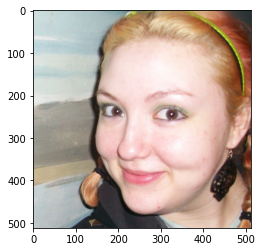

In [ ]:
path = "/content/affectNetHQDB"

######## Write your code here ########
InterestedImage = image.imread(path+"/anger/image0000006.jpg")
plt.figure()
plt.imshow(InterestedImage)
DisaapointedImage = image.imread(path+"/fear/image0000284.jpg")
plt.figure()
plt.imshow(DisaapointedImage)
NeutralImage = image.imread(path+"/happy/ffhq_1.png")
plt.figure()
plt.imshow(NeutralImage)
print(NeutralImage.shape)
print(DisaapointedImage.shape)
print(NeutralImage.shape)

In [ ]:
!rm -r /content/affectNetHQDB/runs

rm: cannot remove '/content/affectNetHQDB/runs': No such file or directory


In [ ]:
train_loader, test_loader, val_loader = load_data(path, 0.2, 0.1, 32, (128, 128))
print(len(train_loader), len(test_loader), len(val_loader))

230 66 33


In [ ]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

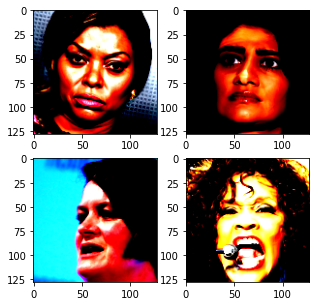

In [ ]:
plot_data_loader(train_loader, (2, 2))

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=None)
n_classes = 7

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


Device: cuda:0


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device);

Device: cuda:0


In [ ]:
for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        print(images.shape)
        #print(labels)
        if i == 5:
          break

torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])


In [ ]:
def evaluate(model, test_loader):
  model.eval() 
  with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
      images, labels = data[0].to(device), data[1].to(device)
      labels=torch.flatten(labels)
      outputs = model(images)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  accuracy = (correct / total) * 100
  model.train()
  return accuracy, loss.item()

In [ ]:
def saveModel():
  PATH = "/content/drive/MyDrive/AI/Models/MobileNet_affectnethq.pt"
  torch.save(model.state_dict(), PATH)

In [ ]:
num_epochs = 30
total_steps = len(train_loader)
t1 = time.time()

training_loss = []
training_accuracy = []
validation_loss = []
validation_accuracy = []



for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 50 == 0:
            val_accu, val_loss = evaluate(model, test_loader)
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}, val_loss: {:.4f}, val_accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),(correct / total) * 100, val_loss, val_accu))
            training_loss.append(loss.item())
            training_accuracy.append((correct / total) * 100)
            validation_accuracy.append(val_accu)
            validation_loss.append(val_loss)
            
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
saveModel()

Epoch [1/30], Step [50/230], Loss: 2.0795, Accuracy: 9.38, val_loss: 2.8525, val_accuracy: 15.48%
Epoch [1/30], Step [100/230], Loss: 2.0193, Accuracy: 15.62, val_loss: 1.9443, val_accuracy: 18.14%
Epoch [1/30], Step [150/230], Loss: 1.9887, Accuracy: 9.38, val_loss: 2.0099, val_accuracy: 16.71%
Epoch [1/30], Step [200/230], Loss: 1.9746, Accuracy: 3.12, val_loss: 1.8805, val_accuracy: 14.38%
Epoch [2/30], Step [50/230], Loss: 1.9610, Accuracy: 28.12, val_loss: 1.9158, val_accuracy: 14.90%
Epoch [2/30], Step [100/230], Loss: 1.9217, Accuracy: 18.75, val_loss: 1.9586, val_accuracy: 17.76%
Epoch [2/30], Step [150/230], Loss: 1.8320, Accuracy: 21.88, val_loss: 1.8552, val_accuracy: 23.24%
Epoch [2/30], Step [200/230], Loss: 1.6197, Accuracy: 43.75, val_loss: 1.6613, val_accuracy: 27.52%
Epoch [3/30], Step [50/230], Loss: 1.5941, Accuracy: 34.38, val_loss: 1.4597, val_accuracy: 29.67%
Epoch [3/30], Step [100/230], Loss: 1.5298, Accuracy: 31.25, val_loss: 1.3464, val_accuracy: 31.90%
Epoch 

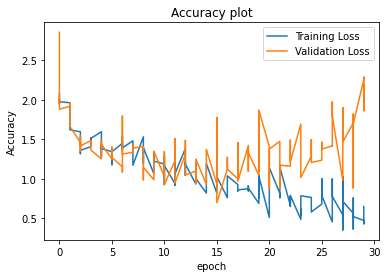

In [ ]:
epochs = [int(i/4) for i in range(num_epochs*4)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

plt.plot(epochs,training_loss,label='Training Loss')
plt.plot(epochs,validation_loss,label='Validation Loss')

plt.legend()
plt.savefig('Loss_MobileNet_affectnetHQ.png')

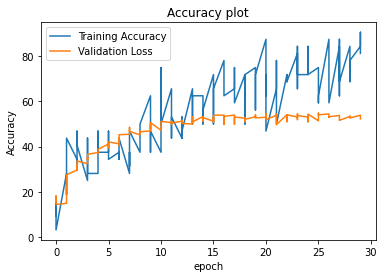

In [ ]:
epochs = [int(i/4) for i in range(num_epochs*4)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

plt.plot(epochs,training_accuracy,label='Training Accuracy') 
plt.plot(epochs,validation_accuracy,label='Validation Loss')

plt.legend()
plt.savefig('Accuracy_MobileNet_affectnetHQ.png')

[[151  47   0   0   0   0   0]
 [  0  66   0   0   0   0   0]
 [  0   0 197   0   0   0   1]
 [  0   0   0 132   0   0   0]
 [  0   0   0 129 333   0   0]
 [ 66   0   0   0   0 198   0]
 [  0   0   0   0   0   0 132]]
              precision    recall  f1-score   support

    surprise       0.70      0.76      0.73       198
     neutral       0.58      1.00      0.74        66
       anger       1.00      0.99      1.00       198
         sad       0.51      1.00      0.67       132
       happy       1.00      0.72      0.84       462
        fear       1.00      0.75      0.86       264
     disgust       0.99      1.00      1.00       132

    accuracy                           0.83      1452
   macro avg       0.83      0.89      0.83      1452
weighted avg       0.89      0.83      0.84      1452



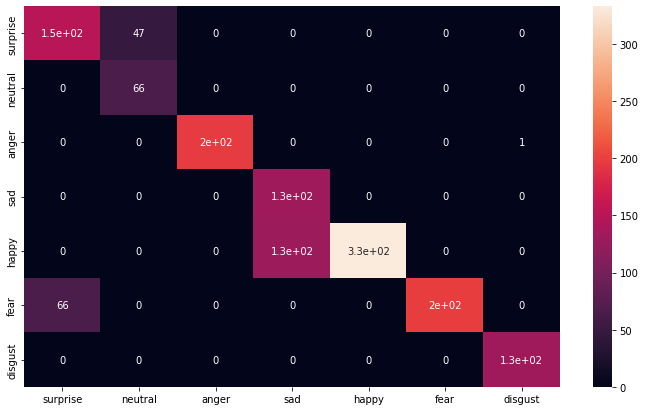

In [ ]:
y_pred = []
y_true = []

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

for inputs, labels in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('surprise', 'neutral', 'anger', 'sad', 'happy', 'fear', 'disgust')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

import seaborn as sns

# sns.heatmap(cf_matrix, annot=True)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('Confusion_matrix_MobileNet_affectnetHQ.png')
print(classification_report(y_true, y_pred, target_names=['surprise', 'neutral', 'anger', 'sad', 'happy', 'fear', 'disgust']))